# TS Prophet
## Data split in training and test. The last 365 days are the test data.

In [1]:
from audioop import cross
import itertools
from matplotlib import units
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.serialize import model_to_json, model_from_json

plt.style.use('fivethirtyeight')

from sklearn.metrics import mean_absolute_error,mean_squared_error

from green_city.utils import metrics_dict, datetime2index, index2datetime

# Libraries to reduce Prophet verbose output
import warnings
import logging
import os

%matplotlib inline

In [2]:
## MLFLOW ##
import mlflow
from green_city.mlflow_config import get_mlflow_config

flow_conf = get_mlflow_config()
tracking_uri = flow_conf["TRACKING_URI"]
mlflow.set_tracking_uri(flow_conf["TRACKING_URI"])
mlflow.set_experiment(flow_conf["EXPERIMENT_NAME"]);

In [3]:
def is_winter_season(ds):
    """Classifies the dates into Winter or Summer

    Args:
        ds (datetime series): A Pandas datetime series
    """
    date = pd.to_datetime(ds)
    return(date.month < 4 or date.month > 9)


In [4]:
## DB CONNECTION ##
from sqlalchemy import create_engine
from decouple import Config, RepositoryEnv

config = Config(RepositoryEnv("../.db_credentials"))

db_connection_credentials = {
    "database": config('POSTGRES_DB'),
    "user": config('POSTGRES_USER'),
    "password": config('POSTGRES_PASSWORD'),
    "host": config('POSTGRES_HOST'),
    "port": config('POSTGRES_PORT'),
}
DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
db = create_engine(DB_STRING)

### Load data and feature engineering

In [5]:
# building = 5
# # Load data
# df_building = pd.read_csv(f"../data/preprocessed/Building_{building}.csv").astype({'datetime': 'datetime64'})#.set_index('datetime')

In [5]:
building = "All"
# Load data
df_building = pd.read_csv(f"../data/preprocessed/Agg_buildings.csv").astype({'datetime': 'datetime64'})#.set_index('datetime')

In [6]:
df_building = df_building.rename(columns={'datetime':'ds',
                                    'net_load_kW':'y'})
# df.head(5)

In [7]:
df_building.y.describe()

count    35040.000000
mean       234.126324
std        165.718885
min        -39.048000
25%        109.621000
50%        171.736000
75%        327.718000
max        871.501000
Name: y, dtype: float64

In [8]:
df_building['winter'] = df_building['ds'].apply(is_winter_season)
df_building['summer'] = ~df_building['ds'].apply(is_winter_season)

In [9]:
df_holiday = df_building[['ds','holiday']].query('holiday')
df_holiday['holiday'] = 'Holiday'
# df_holiday

## In the development stage, it was explored to add the workday as part of the  ##
## seasonality. It did not had an effect. Including the holiday did.            ##
# df_workday = df[['ds','workday']].query('workday')
# df_workday['holiday'] = 'Workday'
# df_workday = df_workday.drop('workday', axis=1)

# df_holidays = pd.concat([df_holiday, df_workday], ignore_index=True)

In [10]:
pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]
# pred_indices = [32135]

## Prophet simple model. Three years training

### Split data in training and test data

In [11]:
df_simple_model_train = df_building[:365*3*24]
df_simple_model_test = df_building[365*3*24:]

### Simple Prophed model. Specify 95% of uncertainty and additive model. (Default 80% and additive model)

In [12]:
my_model_simple = Prophet(interval_width = 0.95, seasonality_mode="additive")

In [13]:
my_model_simple.fit(df_simple_model_train)

Initial log joint probability = -797.247
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       46186.3     0.0235664       1138.72           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         46212    0.00694089       156.716           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       46222.2     0.0906791       815.911           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       46227.2    0.00012776       234.729   1.457e-06       0.001      507  LS failed, Hessian reset 
     399       46227.3   0.000157466       70.3005           1           1      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       46231.5     0.0200195    

In [15]:
# Save model
with open('../models/my_model_simple.json', 'w') as fout:
    fout.write(model_to_json(my_model_simple))  

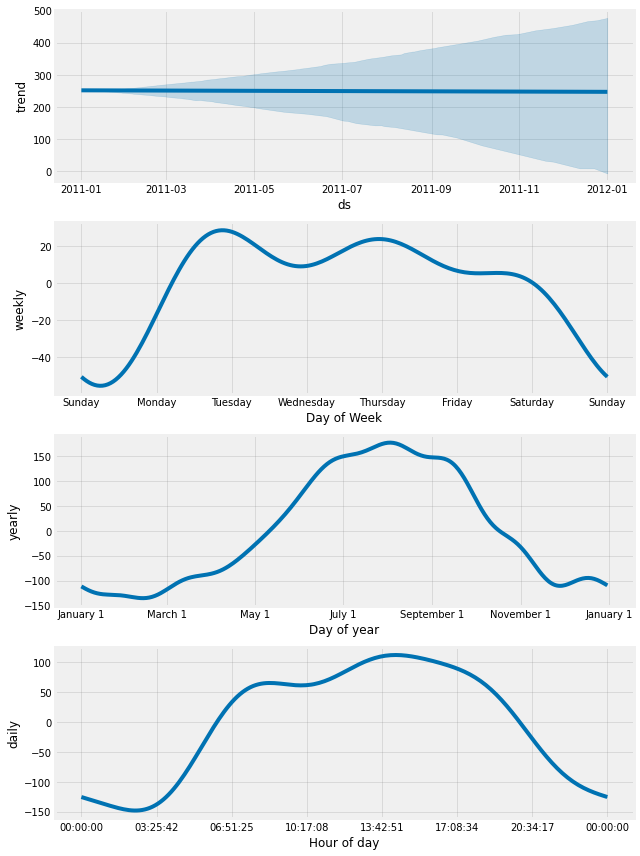

In [17]:
df_predict = my_model_simple.predict(df_simple_model_test)
_=my_model_simple.plot_components(df_predict)

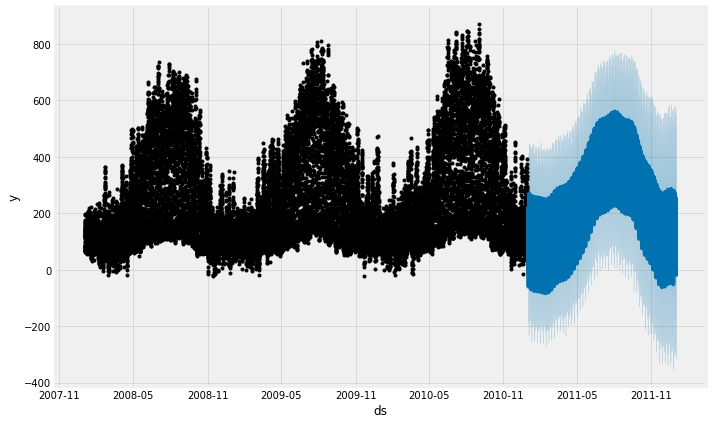

In [18]:
_=my_model_simple.plot(df_predict)

### Predicting 8 days with basic model

In [19]:
def my_pred(df,model_name, params, pred_index):
    """Forecast a specified interval into a Prophet model. 

    Args:
        df (dataframe)    : A pandas dataframe with the form required by Prophet. Must include the training and testing data.
        model_name (str)  : A string with a unique description of the model to evaluate.
        params(list) : A list of dictionaries with the parameters definition. 
        pred_index (list) : A list with the indexes of the intervals to predict. ("Test data"). These indexes must exist in the df variable.

    Returns:
        forecasts (dataframe)           : A dataframe with the forecasted values from the interval of interest. 
        ls_best_params (list)           : A list with the best hyperpameters and its evaluation metrics; mse and rsme.
        my_model(fitted Prophet model)  : A fitted prophet model. The model utilized to forecast the data. 
        ls_publish                      : A list with the information to put in mlflow and the SQL server. Includes the forecasts dataframe,
                                          the msa, mse and r2_score.
    """

    # ls_best_params = []
    ls_publish = []
    for index in pred_index:
        df_train=df.loc[:index] # dataframe to train the model and its optimization (this was a mistake)
        df_future = df.loc[index+1:index+24]
        with mlflow.start_run(run_name=model_name) as r:
            ### Predict ##
            # best_params, tuning_results = my_prophet_mse(df_train, all_params=parameters) # The optimized parameters are coming form the 3 years training data
            # ls_best_params.append([{'index':index}, best_params, tuning_results]) # This is not required anymore.
            my_model = Prophet(**params)
            my_model.fit(df_train)

            ## Save Model##
            with open(f'../models/{model_name}_{index}.json', 'w') as fout:
                fout.write(model_to_json(my_model_simple))  

            df_forecast = my_model.predict(df_future)
            df_forecast.index = df_future.index
            df_forecast.index.name = 'id'
            df_forecast['error'] = df_future.y - df_forecast.yhat
            df_forecast = df_forecast[['yhat', 'error']]
            
            ## Evaluate ##
            metrics = metrics_dict(df_future.y, df_forecast.yhat, ["mae", "mse", "r2_score"])
            print(index)
            print("mae: {mae}, mse: {mse}, r2: {r2_score}".format(**metrics))
            # print(ls_best_params)
            mlflow.log_metrics(metrics)

            ## Parameters log ##
            mlflow_params = {
                'building_nr': building,
                'feature':'net_load_kW',
                'index':index,
                'model': 'Prophet',
                'pred_steps':24,
                'resolution':'H',
                'datetime':index2datetime(index)
            }
            mlflow.log_params(mlflow_params)

            forecasts = df_forecast[['yhat']].assign(run_id = r.info.run_id).rename(columns={"yhat": "prediction"})
            # forecasts.to_sql("forecast", con=db, if_exists="append")
            ls_publish.append([{'index':index,'metrics':metrics, 'params':params, 'forecast':forecasts}])
    return forecasts, my_model, ls_publish

In [17]:
# Use MSE for tunning 
param_grid_simple = {
    'interval_width': [0.95],
    'seasonality_mode':['additive'],
    'changepoint_prior_scale':[0.05],
    'seasonality_prior_scale':[10.0],
    'holidays_prior_scale':[0.01],
    'changepoint_range':[0.8]
}
my_simple_params = [dict(zip(param_grid_simple.keys(), v)) for v in itertools.product(*param_grid_simple.values())]


In [18]:
pred_mse_simpleMod, \
    my_model_simpleMod, \
    ls_publish_mse_simpleMod = my_pred(df = df_building,
        model_name='Prophet Simple Model', 
        params=my_simple_params[0],
        pred_index=pred_indices)

Initial log joint probability = -836.881
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       56517.6    0.00394313       739.778      0.2141           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       56535.9    0.00087403       139.267           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       56540.5     0.0101049        321.16           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       56544.4    0.00122932       126.066           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     433         56545   0.000100472       248.198   6.401e-07       0.001      563  LS failed, Hessian reset 
     499       56545.4   0.000197462    

## Optimize modeling. Find best hyper parameters

In [19]:
def my_prophet_find_hyperparameter(df, all_params):
    """Determine the best hyper parameters for a Prophet model.
    It uses a base Prophet model. 

    Args:
        df (dataframe): A pandas dataframe with the required Prophet structure
        all_params (list of dictionaries): A list of dictionaries with the parameters definition. 

    Returns:
        best_params: a list with the best parameters
        tuning_results: A dataframe with the mse and rmse evaluation of the parameters combinations
    """
    warnings.simplefilter("ignore", DeprecationWarning)
    warnings.simplefilter("ignore", FutureWarning)
    logging.getLogger('prophet').setLevel(logging.ERROR) #Notice that i had modified the name from 'fbprophet' to just 'prophet'
    mses = []
    rmses = []
    c=0
    for params in all_params:
        c += 1
        m = Prophet(**params)
        m.fit(df)
        ## Save Model##
        with open(f'../models/Prophet_paramSearch_{c}.json', 'w') as fout:
            fout.write(model_to_json(my_model_simple))  
        print(c)
        df_cv = cross_validation(m, horizon='180 days', parallel='processes')
        df_p = performance_metrics(df_cv, rolling_window=1)
        mses.append(df_p['mse'].values[0])
        rmses.append(df_p['rmse'].values[0])
    tuning_results = pd.DataFrame(all_params)
    tuning_results['mse'] = mses
    tuning_results['rmse'] = rmses
    print(tuning_results)
    best_params=all_params[np.argmin(mses)]
    print(best_params)
    return best_params, tuning_results


### Parameters that can be tuned

**changepoint_prior_scale**: This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of 0.05 works for many time series, but this could be tuned; a range of [0.001, 0.5] would likely be about right. Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.

**seasonality_prior_scale**: This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.

**holidays_prior_scale**: This controls flexibility to fit holiday effects. Similar to seasonality_prior_scale, it defaults to 10.0 which applies basically no regularization, since we usually have multiple observations of holidays and can do a good job of estimating their effects. This could also be tuned on a range of [0.01, 10] as with seasonality_prior_scale.

**seasonality_mode**: Options are ['additive', 'multiplicative']. Default is 'additive', but many business time series will have multiplicative seasonality. This is best identified just from looking at the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series (see the documentation here on multiplicative seasonality), but when that isn’t possible, it could be tuned.

In [20]:
# Parameter optimization. Tunning CV with MSE 
param_grid = {
    'interval_width': [0.95],
    'seasonality_mode':['additive'],
    'changepoint_prior_scale':[0.0001, 0.01, 0.05, 0.1, 0.5], #Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.
    'seasonality_prior_scale':[0.01, 0.1, 1.0, 10.0], #This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.
    'holidays_prior_scale':[0.01, 0.1, 1.0, 10.0],
    'changepoint_range':[0.8,0.9]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

## Do not run. It takes 95m. The results are in the next code block

In [21]:
# my_optimized_parameters, \
#     my_optimized_param_tunning_results = \
#         my_prophet_find_hyperparameter(df_simple_model_train, all_params)

In [22]:
# my_optimized_parameters

In [23]:
### All buildings hyperparameters ###
my_optimized_parameters = {'interval_width': 0.95,
    'seasonality_mode': 'additive',
    'changepoint_prior_scale': 0.01,
    'seasonality_prior_scale': 0.01,
    'holidays_prior_scale': 0.01,
    'changepoint_range': 0.8}

In [24]:
### Building 5 hyperparameters ###
# my_optimized_parameters = {'interval_width': 0.95,
#     'seasonality_mode': 'additive',
#     'changepoint_prior_scale': 0.0001,
#     'seasonality_prior_scale': 0.01,
#     'holidays_prior_scale': 0.01,
#     'changepoint_range': 0.9}

In [25]:
# # Save the hyperparameters results from cross validation. RMSE and MSE are documented.
# my_optimized_param_tunning_results
# my_optimized_param_tunning_results.to_csv('../data/preprocessed/prophet_best_hyperparameters_bld_5.csv',
#     sep=";", index_label='Index')

In [26]:
# # Save the hyperparameters results from cross validation. RMSE and MSE are documented.
# my_optimized_param_tunning_results
# my_optimized_param_tunning_results.to_csv('../data/preprocessed/prophet_best_hyperparameters_allbld.csv',
#     sep=";", index_label='Index')

### Evaluate best hyperparameters

In [27]:
pred_simpleMod_Opt, \
        my_model_simpleMod_Opt, \
        ls_publish_simpleMod_Opt = my_pred(df = df_building,
        model_name='Prophet Simple Model Optimized Parameters - Tunning with MSE', 
        params=my_optimized_parameters,
        pred_index=pred_indices)

Initial log joint probability = -836.881
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       56186.9   0.000990547       554.411      0.4956      0.4956      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       56190.7   0.000921411       402.485      0.6119           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       56193.1     0.0002702       1019.53   4.032e-07       0.001      312  LS failed, Hessian reset 
     299       56196.5   0.000181565       397.744           1           1      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       56196.7   8.94234e-05       502.232   1.684e-07       0.001      470  LS failed, Hessian reset 
     349       56196.8   7.64213e-06         346.8    2.27e-08       0.001      552  LS failed, Hessian rese

### Add holidays

In [98]:
param_grid = {
    'interval_width': [0.95],
    'seasonality_mode':['additive'],
    'changepoint_prior_scale':[0.01],
    'seasonality_prior_scale':[0.01],
    'holidays_prior_scale':[0.01],
    'changepoint_range':[0.8],
    'holidays':[df_holiday]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

pred_Opt_holidays, \
    m_best_Opt_holidays, \
    ls_publish_Opt_holidays = my_pred(df = df_building,
        model_name='Prophet Holidays-Optimized-Parameters - Tunning with MSE', 
        params=all_params[0],
        pred_index=pred_indices)

Initial log joint probability = -836.881
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       56250.3    0.00184345        663.04           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       56254.1   0.000157259       674.469   1.407e-07       0.001      206  LS failed, Hessian reset 
     193       56256.8   9.67561e-05       471.375   1.267e-07       0.001      340  LS failed, Hessian reset 
     199       56256.9   7.85094e-05       355.105      0.8037      0.8037      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231         56257   7.72303e-07       270.482      0.3184           1      396   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
32135
mae: 51.78993585536756, mse: 3540.7305451252673, r2: 0.8256438182287673
Initial log join

### Add outdoor temperature, humidity, diffuse and direct solar energy as additional regressor. 
### The temperature, humidity and solar energy data is in the original dataset.

In [20]:
def my_pred_reg(df,model_name, params, pred_index, shift=False):
    """Forecast a specified interval into a Prophet model. 

    Args:
        df (dataframe)    : A pandas dataframe with the form required by Prophet. Must include the training and testing data.
        model_name (str)  : A string with a unique description of the model to evaluate.
        params(list) : A list of dictionaries with the parameters definition. 
        pred_index (list) : A list with the indexes of the intervals to predict. ("Test data"). These indexes must exist in the df variable.

    Returns:
        forecasts (dataframe)           : A dataframe with the forecasted values from the interval of interest. 
        ls_best_params (list)           : A list with the best hyperpameters and its evaluation metrics; mse and rsme.
        my_model(fitted Prophet model)  : A fitted prophet model. The model utilized to forecast the data. 
        ls_publish                      : A list with the information to put in mlflow and the SQL server. Includes the forecasts dataframe,
                                          the msa, mse and r2_score.
    """
    if shift:
        df['pred_24h_diffuse_solar_W_m2'] = df['pred_24h_diffuse_solar_W_m2'].shift(periods=24)
        df['pred_24h_direct_solar_W_m2'] = df['pred_24h_direct_solar_W_m2'].shift(periods=24)
        df['pred_24h_outdoor_temp'] = df['pred_24h_outdoor_temp'].shift(periods=24)
        df['pred_24h_outdoor_hum'] = df['pred_24h_outdoor_hum'].shift(periods=24)
        df = df.dropna()
    # ls_best_params = []
    ls_publish = []
    for index in pred_index:
        df_train=df.loc[:index] # dataframe to train the model and its optimization (this was a mistake)
        df_future = df.loc[index+1:index+24]
        with mlflow.start_run(run_name=model_name) as r:
            ### Predict ##
            # best_params, tuning_results = my_prophet_mse(df_train, all_params=parameters) # The optimized parameters are coming form the 3 years training data
            # ls_best_params.append([{'index':index}, best_params, tuning_results]) # This is not required anymore.
            my_model = Prophet(**params)
            my_model.add_regressor(name='outdoor_temp')
            my_model.add_regressor(name='outdoor_hum')
            my_model.add_regressor(name='diffuse_solar_W_m2')
            my_model.add_regressor(name='direct_solar_W_m2')
            my_model.add_regressor(name='pred_24h_outdoor_temp')
            my_model.add_regressor(name='pred_24h_outdoor_hum')
            my_model.add_regressor(name='pred_24h_diffuse_solar_W_m2')
            my_model.add_regressor(name='pred_24h_direct_solar_W_m2')
            my_model.fit(df_train) 

            ## Save Model##
            with open(f'../models/{model_name}_{index}.json', 'w') as fout:
                fout.write(model_to_json(my_model_simple))  
            
            df_forecast = my_model.predict(df_future)
            df_forecast.index = df_future.index
            df_forecast.index.name = 'id'
            df_forecast['error'] = df_future.y - df_forecast.yhat
            df_forecast = df_forecast[['yhat', 'error']]
                 
            ## Evaluate ##
            metrics = metrics_dict(df_future.y, df_forecast.yhat, ["mae", "mse", "r2_score"])
            print(index)
            print("mae: {mae}, mse: {mse}, r2: {r2_score}".format(**metrics))
            # print(ls_best_params)
            mlflow.log_metrics(metrics)

            ## Parameters log ##
            mlflow_params = {
                'building_nr': building,
                'feature':'net_load_kW',
                'index':index,
                'model': 'Prophet',
                'pred_steps':24,
                'resolution':'H',
                'datetime':index2datetime(index)
            }
            mlflow.log_params(mlflow_params)

            forecasts = df_forecast[['yhat']].assign(run_id = r.info.run_id).rename(columns={"yhat": "prediction"})
            # forecasts.to_sql("forecast", con=db, if_exists="append")
            ls_publish.append([{'index':index,'metrics':metrics, 'params':params, 'forecast':forecasts}])
    return forecasts, my_model, ls_publish

In [30]:
pred_best_WkMod_RegMod_Opt, \
    m_best_RegMod_Opt, \
    ls_publish_best_RegMod_Opt = my_pred_reg(df=df_building,
        model_name='Prophet Holidays-Regressors-Optimized-Parameters - Tunning with MSE', 
        params=all_params[0],
        pred_index=pred_indices)

Initial log joint probability = -836.881
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       61298.2    0.00395268        1503.2           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       61321.1   9.68111e-05       677.888      0.2729     0.02729      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       61322.4   6.83427e-05        494.82   9.829e-08       0.001      329  LS failed, Hessian reset 
     299       61323.1   5.91629e-05       440.327      0.4987      0.4987      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       61325.6   0.000224592       349.692      0.1909      0.9574      512   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     474       61329.2   0.000122931    

### Stop. The following results are dubious at the moment. (01.08.2022)

### Assume different weekly sesonalities. Summer vs Winter

In [24]:
def my_pred_reg_wk(df,model_name, params, pred_index, shift=False):
    """Forecast a specified interval into a Prophet model. 

    Args:
        df (dataframe)    : A pandas dataframe with the form required by Prophet. Must include the training and testing data.
        model_name (str)  : A string with a unique description of the model to evaluate.
        params(list) : A list of dictionaries with the parameters definition. 
        pred_index (list) : A list with the indexes of the intervals to predict. ("Test data"). These indexes must exist in the df variable.

    Returns:
        forecasts (dataframe)           : A dataframe with the forecasted values from the interval of interest. 
        ls_best_params (list)           : A list with the best hyperpameters and its evaluation metrics; mse and rsme.
        my_model(fitted Prophet model)  : A fitted prophet model. The model utilized to forecast the data. 
        ls_publish                      : A list with the information to put in mlflow and the SQL server. Includes the forecasts dataframe,
                                          the msa, mse and r2_score.
    """
    if shift:
        df['pred_24h_diffuse_solar_W_m2'] = df['pred_24h_diffuse_solar_W_m2'].shift(periods=24)
        df['pred_24h_direct_solar_W_m2'] = df['pred_24h_direct_solar_W_m2'].shift(periods=24)
        df['pred_24h_outdoor_temp'] = df['pred_24h_outdoor_temp'].shift(periods=24)
        df['pred_24h_outdoor_hum'] = df['pred_24h_outdoor_hum'].shift(periods=24)
        df = df.dropna()

    # ls_best_params = []
    ls_publish = []
    for index in pred_index:
        df_train=df.loc[:index] # dataframe to train the model and its optimization (this was a mistake)
        df_future = df.loc[index+1:index+24]
        with mlflow.start_run(run_name=model_name) as r:
            ### Predict ##
            # best_params, tuning_results = my_prophet_mse(df_train, all_params=parameters) # The optimized parameters are coming form the 3 years training data
            # ls_best_params.append([{'index':index}, best_params, tuning_results]) # This is not required anymore.
            my_model = Prophet(**params, weekly_seasonality=False)
            my_model.add_regressor(name='outdoor_temp')
            my_model.add_regressor(name='outdoor_hum')
            my_model.add_regressor(name='diffuse_solar_W_m2')
            my_model.add_regressor(name='direct_solar_W_m2')
            my_model.add_regressor(name='pred_24h_outdoor_temp')
            my_model.add_regressor(name='pred_24h_outdoor_hum')
            my_model.add_regressor(name='pred_24h_diffuse_solar_W_m2')
            my_model.add_regressor(name='pred_24h_direct_solar_W_m2')
            my_model.add_seasonality(name='weekly_on_winter', period = 7, fourier_order= 10, condition_name='winter')
            my_model.add_seasonality(name='weekly_on_summer', period = 7, fourier_order= 10, condition_name='summer')
            my_model.fit(df_train) 

            ## Save Model##
            with open(f'../models/{model_name}_{index}.json', 'w') as fout:
                fout.write(model_to_json(my_model_simple))  

            df_forecast = my_model.predict(df_future)
            df_forecast.index = df_future.index
            df_forecast.index.name = 'id'
            df_forecast['error'] = df_future.y - df_forecast.yhat
            df_forecast['y'] = df_future['y']
            df_forecast = df_forecast[['y','yhat', 'error']]
            
            ## Evaluate ##
            metrics = metrics_dict(df_future.y, df_forecast.yhat, ["mae", "mse", "r2_score"])
            print(index)
            print("mae: {mae}, mse: {mse}, r2: {r2_score}".format(**metrics))
            # print(ls_best_params)
            mlflow.log_metrics(metrics)

            ## Parameters log ##
            mlflow_params = {
                'building_nr': building,
                'feature':'net_load_kW',
                'index':index,
                'model': 'Prophet',
                'pred_steps':24,
                'resolution':'H',
                'datetime':index2datetime(index)
            }
            mlflow.log_params(mlflow_params)

            forecasts = df_forecast[['yhat']].assign(run_id = r.info.run_id).rename(columns={"yhat": "prediction"})
            # forecasts.to_sql("forecast", con=db, if_exists="append")
            ls_publish.append([{'index':index,'metrics':metrics, 'params':params, 'forecast':forecasts, 'errors':df_forecast}])
    return forecasts, my_model, ls_publish

In [25]:
pred_best_WkMod_RegMod_Opt, \
    m_best_WkMod_RegMod_Opt, \
    ls_publish_best_WkMod_RegMod_Opt = my_pred_reg_wk(df=df_building,
        model_name='Prophet Holidays-Wkl-Regressors-Optimized-Parameters - Tunning with MSE', 
        params=all_params[0],
        pred_index=pred_indices)

Initial log joint probability = -836.881
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       67242.9   0.000818122       1744.09      0.8127      0.8127      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       67281.8    0.00188456       1375.59           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       67301.9    0.00324924       1842.97           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       67306.6   0.000116225       571.663      0.7068      0.7068      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       67310.7   0.000374137       848.419           1           1      565   
    Iter      log prob        ||dx||      ||grad||       alpha  

## Asses full model with fourth  year data

In [36]:
pred_best_WkMod_RegMod_Opt, \
    m_best_WkMod_RegMod_Opt, \
    ls_publish_best_WkMod_RegMod_Opt = my_pred_reg_wk(df=df_building,
        model_name='Prophet Holidays-Wkl-Regressors-Optimized-Parameters - Tunning with MSE', 
        params=all_params[0],
        pred_index=[365*3*24])

Initial log joint probability = -845.442
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       55554.1    0.00188882       1434.23           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       55579.5    0.00347485          2616      0.5333           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       55584.2   0.000226535       876.105           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       55588.8   7.64563e-05       687.386   7.359e-08       0.001      496  LS failed, Hessian reset 
     399         55590    0.00153718       1126.24           1           1      508   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     447       55591.3   5.51733e-05    

In [37]:
with open('../models/Prophet Holidays-Wkl-Regressors-Optimized-Parameters - Tunning with MSE_26280.json', 'r') as fin:
    md_26280 = model_from_json(fin.read())  # Load model

In [38]:
df_futures = md_26280.predict(df_simple_model_test)

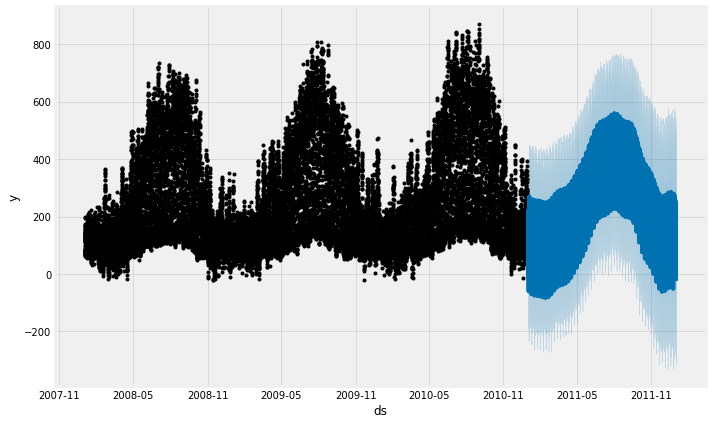

In [40]:
_=md_26280.plot(df_futures)

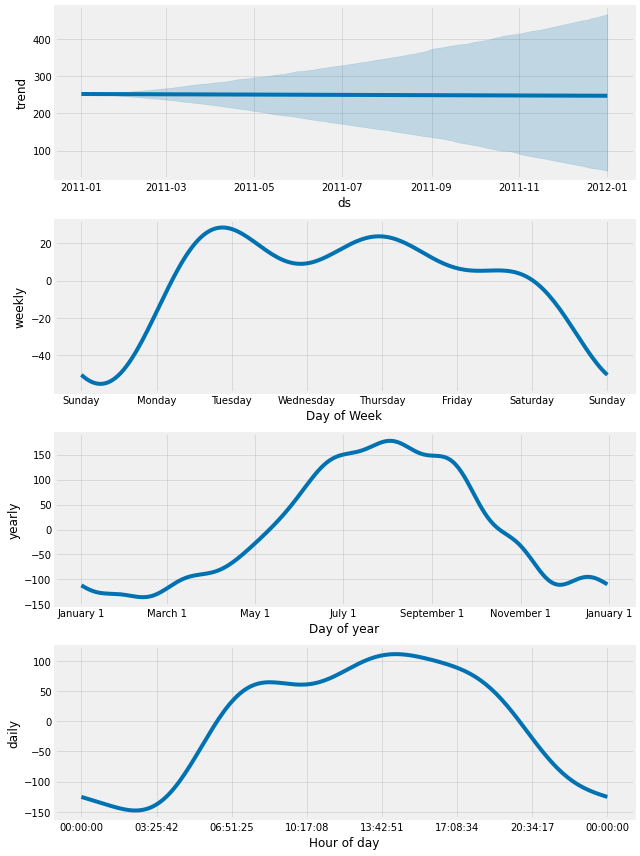

In [41]:
_=md_26280.plot_components(df_futures)

In [85]:
df_asses = df_futures[['ds','yhat']]
df_asses = df_asses.merge(df_simple_model_test[['ds','y']])
df_asses['errors'] = df_asses.y - df_asses.yhat
df_asses


,ds,yhat,y,errors
0,2011-01-01 00:00:00,15.696019,93.386,77.689981
1,2011-01-01 01:00:00,3.271483,91.080,87.808517
2,2011-01-01 02:00:00,-7.918412,87.654,95.572412
3,2011-01-01 03:00:00,-8.280251,91.128,99.408251
4,2011-01-01 04:00:00,14.460363,80.936,66.475637
...,...,...,...,...
8755,2011-12-31 19:00:00,139.270908,100.157,-39.113908
8756,2011-12-31 20:00:00,93.507552,112.394,18.886448
8757,2011-12-31 21:00:00,43.639101,106.193,62.553899
8758,2011-12-31 22:00:00,2.382184,111.619,109.236816


In [124]:
df_asses[0:24*7]

,ds,yhat,y,errors
0,2011-01-01 00:00:00,15.696019,93.386,77.689981
1,2011-01-01 01:00:00,3.271483,91.080,87.808517
2,2011-01-01 02:00:00,-7.918412,87.654,95.572412
3,2011-01-01 03:00:00,-8.280251,91.128,99.408251
4,2011-01-01 04:00:00,14.460363,80.936,66.475637
...,...,...,...,...
163,2011-01-07 19:00:00,177.662364,122.143,-55.519364
164,2011-01-07 20:00:00,133.648808,135.186,1.537192
165,2011-01-07 21:00:00,85.277356,119.747,34.469644
166,2011-01-07 22:00:00,45.235313,107.589,62.353687


<AxesSubplot:xlabel='ds', ylabel='y'>

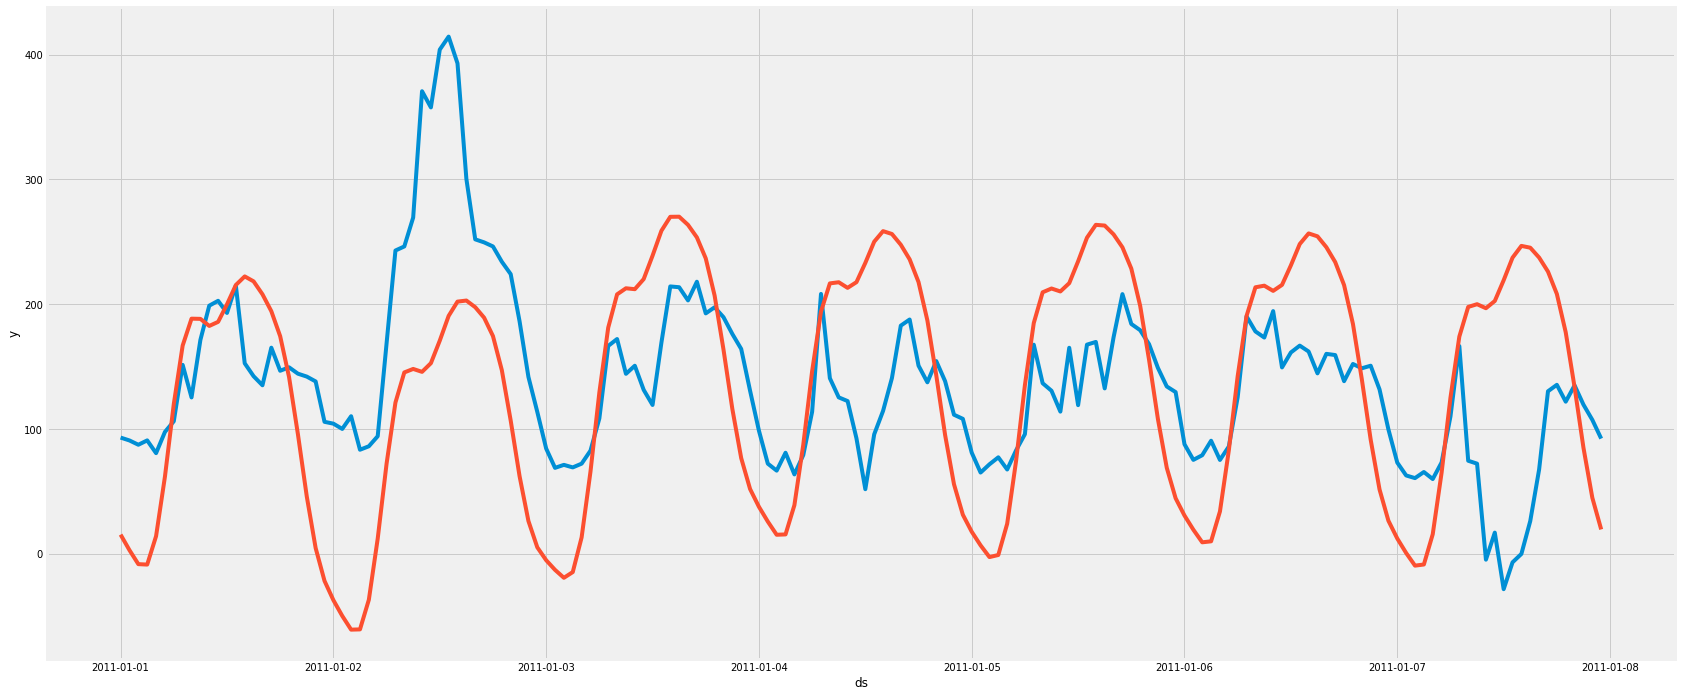

In [125]:
fig, ax = plt.subplots(figsize = (26,12))

sns.lineplot(x = 'ds', y = 'y', data = df_asses[0:24*7])
sns.lineplot(x = 'ds', y = 'yhat', data = df_asses[0:24*7])

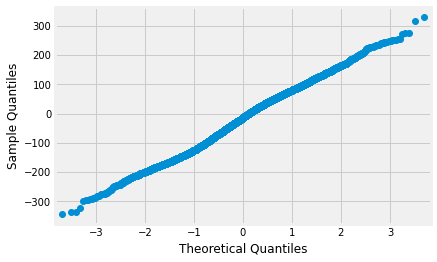

In [95]:
from statsmodels.graphics.gofplots import qqplot
_=qqplot(df_asses['errors'])


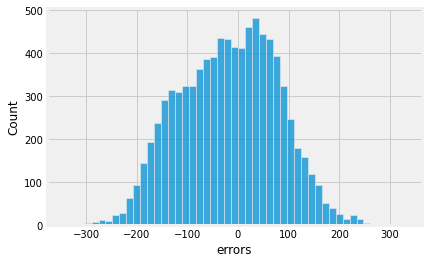

In [96]:
_=sns.histplot(df_asses['errors'])

In [99]:
df_history = md_26280.predict()

In [100]:
df = pd.merge(df_simple_model_train, df_history, on ='ds')
residuals = df['yhat']-df['y']

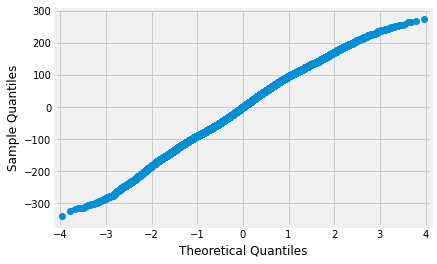

In [118]:
# fig, ax = plt.subplots(figsize=(25,10))
_=qqplot(residuals)


<AxesSubplot:ylabel='Count'>

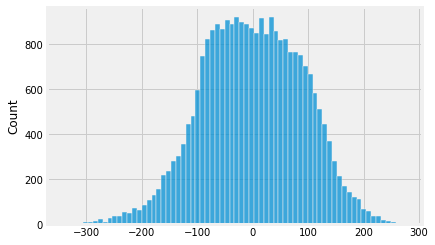

In [106]:
fig, ax = plt.subplots(figsize=(25,10))
sns.histplot(residuals)

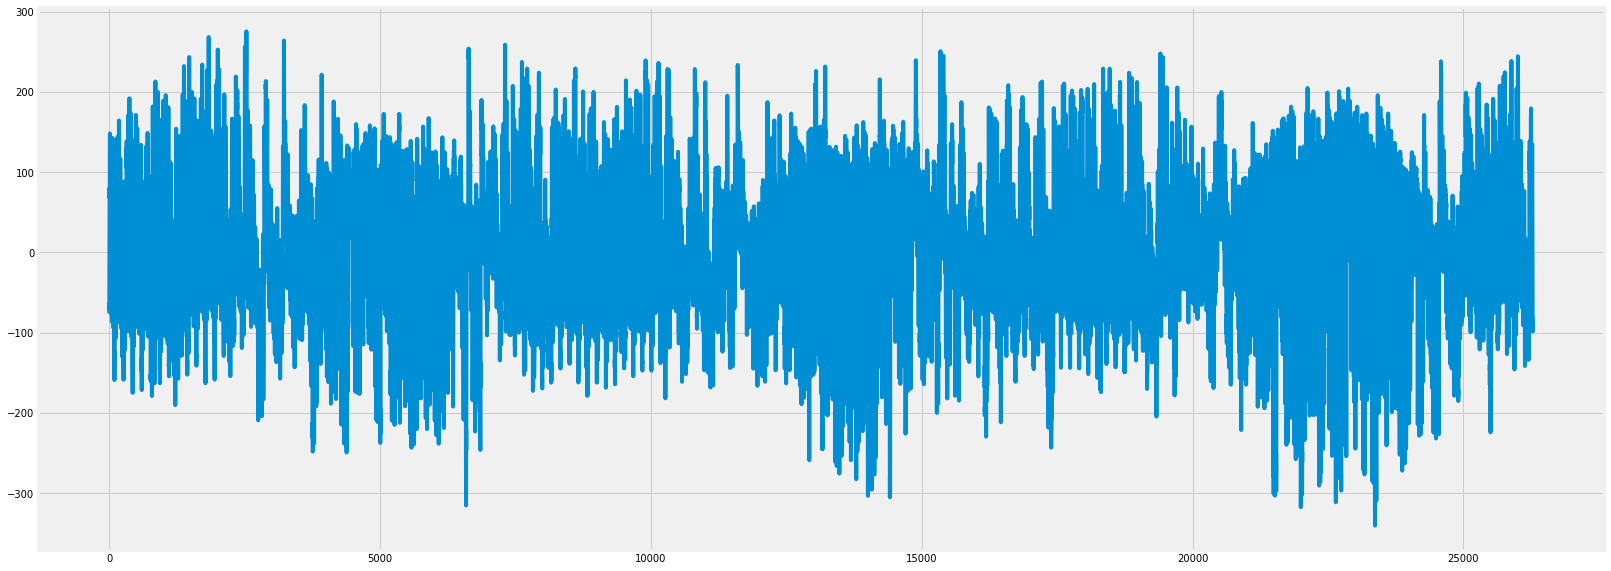

In [115]:
fig, ax = plt.subplots(figsize=(25,10))
ax = plt.plot(residuals)